In [1]:
import glob
import os
import requests
import time
import warnings

warnings.simplefilter('ignore', FutureWarning)

from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# sns.set_style(style='whitegrid')
device_num = 0
torch.cuda.set_device(device_num)

# Полносвязные нейросети

Цель этой части занятия - знакомство с полносвязными нейросетями на примере задачи классификации ирисов. 

**План:**
- Построение простейшей полносвязной нейросети;
- Реализация training loop -- её обучения;
- Замеры качества нейросети как классификатора.


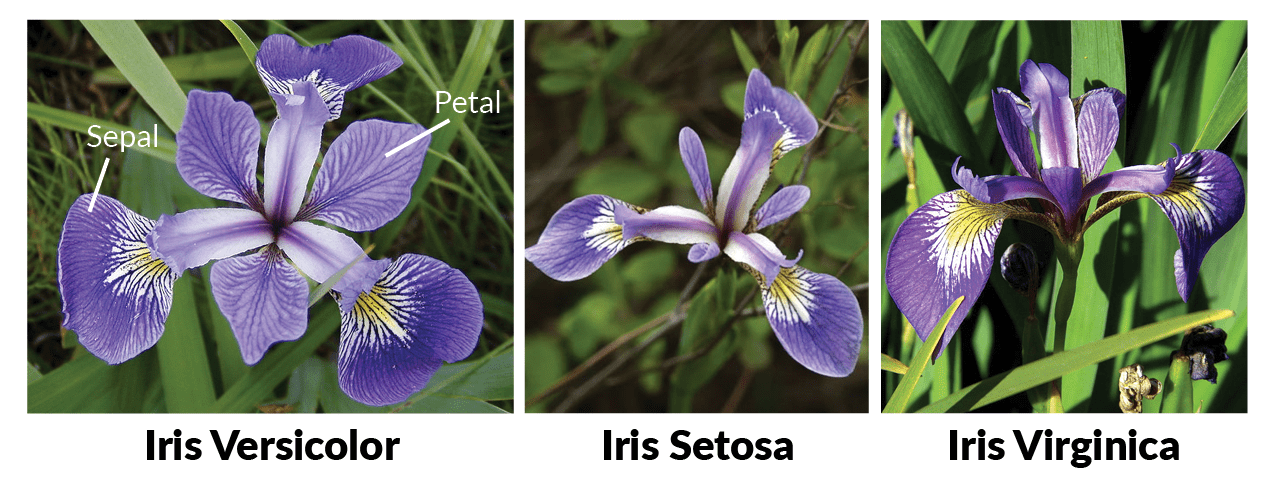

In [2]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=179
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
X.shape

(150, 4)

In [4]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

Посмотрим на данные, используя код из занятия по `seaborn`.

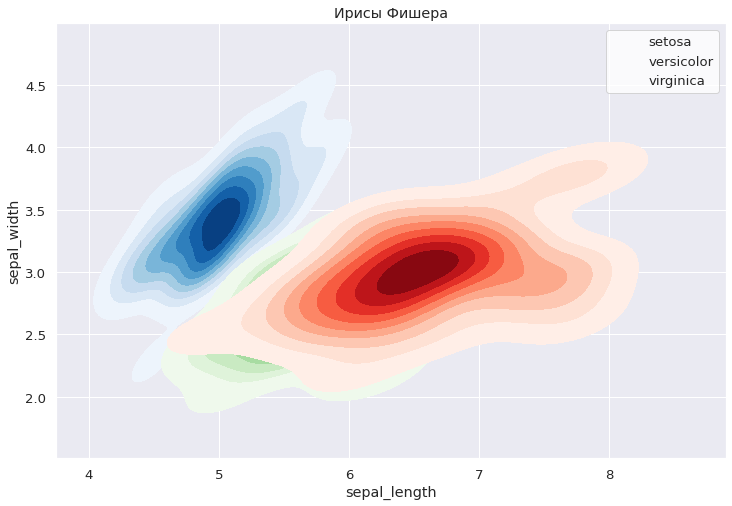

In [5]:
sns_iris = sns.load_dataset('iris')
setosa = sns_iris[y == 0]
versicolor = sns_iris[y == 1]
virginica = sns_iris[y == 2]

plt.figure(figsize=(12, 8))
with sns.axes_style("darkgrid"):
    ax = sns.kdeplot(
        setosa.sepal_length, 
        setosa.sepal_width, 
        label="setosa", 
        cmap='Blues',
        fill=True
    )
    ax = sns.kdeplot(
        versicolor.sepal_length, 
        versicolor.sepal_width, 
        label="versicolor", 
        cmap='Greens',
        fill=True
    )
    ax = sns.kdeplot(
        virginica.sepal_length, virginica.sepal_width, 
        label="virginica", 
        cmap='Reds',
        fill=True
    )
    ax.set_title("Ирисы Фишера");
    ax.legend().get_frame().set_facecolor("white");

Реализуем простейшую полносвязную архитектуру -- **перцептрон с одним скрытым слоем**. В качестве функций активации между внутренними слоями будем использовать ReLU -- эта функция практически не ухудшает эффективность алгоритма распространения ошибки, но при этом привносит достаточную нелинейность, чтобы быть полезной.

---

Любая нейросетевая архитектура на PyTorch должна быть наследником класса nn.Module, в котором реализованы заглушки методов `forward` -- пропускания данных через нейросеть -- и `backward` -- вычисления градиентов. 

Само составление архитектуры нейросети можно воспринимать как конструктор: вы собираете её из набора блоков, которые "сшиваются" вместе при построении вычислительного графа, по которому PyTorch понимает, как вычислять градиенты методом автоматического дифференцирования. 

Интересно, что в PyTorch этот граф динамический: он сбрасывается после каждого вычисления градиентов, потому структуру сети можно изменять в процессе обучения. В частности, такой подход позволил NVIdia впервые сгенерировать реалистичные человеческие лица в высоком разрешении.

## Задание 1. 0,5 балла
1. Добавьте к сети еще один скрытый слой, не забудьте в аргумент функции включить hidden_dim_2

In [6]:
class IrisPerceptron(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, hidden_dim_2: int):
        super().__init__()
        self.n_classes = 3
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),

            # Добавляем еще один скрытый слой
            nn.Linear(hidden_dim, hidden_dim_2),
            nn.ReLU(),

            nn.Linear(hidden_dim_2, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, self.n_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.net(x)

Кроме модели нам понадобится функция ошибок, которую традиционно называют `criterion`, и метод оптимизации, который здесь нужно создавать и использовать явно, в отличие от алгоритмов, с которыми мы работали ранее.

In [7]:
device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

## Задание 2. 3 балла
1. Укажите произвольный (на ваше усмотрение) hidden_dim и hidden_dim_2
2. Попробуйте поварьировать градиентный шаг (от 0.0001 до 0.1) в оптимизаторе Adam. После каждого изменения шага обучите Вашу модель, сделайте вывод при каком шаге градиента модель сходится к решению быстрее. Под скоростью сходимости тут подразумевается кол-во эпох, необходимых для обучения модели
3. Попробуйте также поварьировать hidden_dim и hidden_dim_2, чтобы получить лучший loss и accuracy на тестовом наборе


### Модель с learning rate = 0.001

In [8]:
model = IrisPerceptron(
    input_dim=X_train.shape[1], 
    hidden_dim=10,
    hidden_dim_2=30,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Посмотрим на нашу нейросеть

In [9]:
model

IrisPerceptron(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=3, bias=True)
    (7): Softmax(dim=1)
  )
)

**Напишем простейший training loop:**

- Пропустили данные через нейросеть;
- Вычислили функцию ошибок;
- Посчитали градиенты по всем обучаемым параметрам;
- Сделали шаг алгоритма backpropagation.

Простейший потому, что ирисы Фишера это маленький датасет, он целиком помещается на GPU. Т.е. нам не нужно нарезать данные на батчи, в связи с чем количество кода сильно уменьшается.

  0%|          | 0/100 [00:00<?, ?it/s]


               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.50      0.67        10
           2       0.67      1.00      0.80        10

    accuracy                           0.83        30
   macro avg       0.89      0.83      0.82        30
weighted avg       0.89      0.83      0.82        30



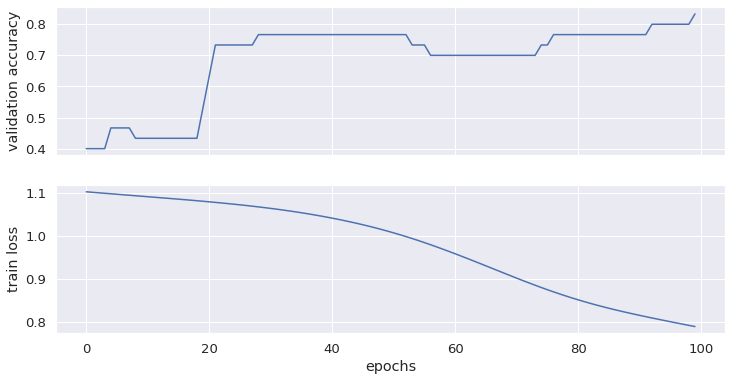

In [10]:
EPOCHS  = 100

X_train = torch.tensor(X_train, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

loss_list = np.zeros((EPOCHS,))
loss_test_list = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm(range(EPOCHS)):
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.float)
        accuracy_list[epoch] = correct.mean().item()

model.eval()

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("train loss")
ax2.set_xlabel("epochs")

with torch.no_grad():
    y_pred = np.argmax(model(X_test).detach().cpu().numpy(), axis=1)

print('\n',
    classification_report(
        y_test.detach().cpu().numpy(), 
        y_pred
    )
)

### Модель с learning rate = 0.01

In [11]:
model_lr001 = IrisPerceptron(
    input_dim=X_train.shape[1], 
    hidden_dim=10,
    hidden_dim_2=30,
).to(device)
optimizer_lr001 = torch.optim.Adam(model_lr001.parameters(), lr=0.01)
criterion_lr001 = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy constru

  0%|          | 0/100 [00:00<?, ?it/s]


               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



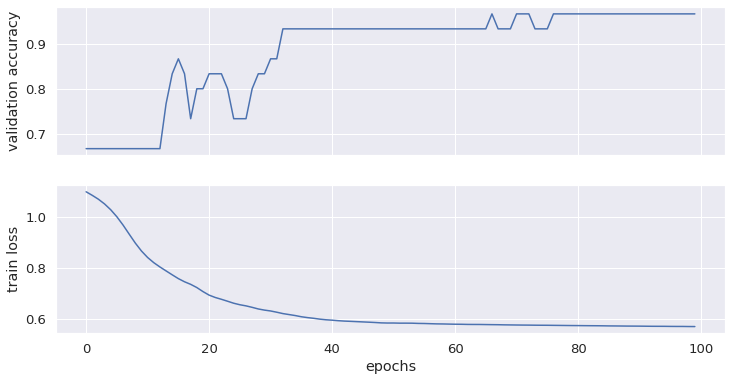

In [12]:
EPOCHS  = 100

X_train = torch.tensor(X_train, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

loss_list_model_lr001 = np.zeros((EPOCHS,))
accuracy_list_model_lr001 = np.zeros((EPOCHS,))

for epoch in tqdm(range(EPOCHS)):
    model_lr001.train()
    y_pred = model_lr001(X_train)
    loss_model_lr001 = criterion_lr001(y_pred, y_train)
    loss_list_model_lr001[epoch] = loss_model_lr001.item()
    
    optimizer_lr001.zero_grad()
    loss_model_lr001.backward()
    optimizer_lr001.step()
    
    with torch.no_grad():
        y_pred = model_lr001(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.float)
        accuracy_list_model_lr001[epoch] = correct.mean().item()

model_lr001.eval()

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list_model_lr001)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list_model_lr001)
ax2.set_ylabel("train loss")
ax2.set_xlabel("epochs")

with torch.no_grad():
    y_pred = np.argmax(model_lr001(X_test).detach().cpu().numpy(), axis=1)

print('\n',
    classification_report(
        y_test.detach().cpu().numpy(), 
        y_pred
    )
)

Модель обучилась быстрее, качество улучшилось

### Модель с learning rate = 0.05

In [13]:
model_lr005 = IrisPerceptron(
    input_dim=X_train.shape[1], 
    hidden_dim=10,
    hidden_dim_2=30,
).to(device)
optimizer_lr005 = torch.optim.Adam(model_lr005.parameters(), lr=0.05)
criterion_lr005 = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy constru

  0%|          | 0/100 [00:00<?, ?it/s]


               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



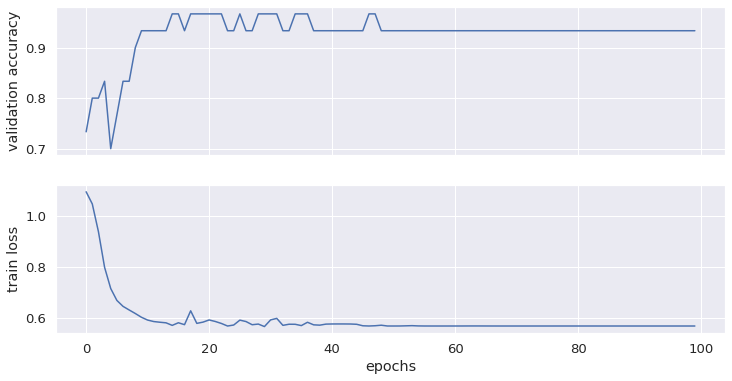

In [14]:
EPOCHS  = 100

X_train = torch.tensor(X_train, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

loss_list_model_lr005 = np.zeros((EPOCHS,))
accuracy_list_model_lr005 = np.zeros((EPOCHS,))

for epoch in tqdm(range(EPOCHS)):
    model_lr005.train()
    y_pred = model_lr005(X_train)
    loss_model_lr005 = criterion_lr005(y_pred, y_train)
    loss_list_model_lr005[epoch] = loss_model_lr005.item()
    
    optimizer_lr005.zero_grad()
    loss_model_lr005.backward()
    optimizer_lr005.step()
    
    with torch.no_grad():
        y_pred = model_lr005(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.float)
        accuracy_list_model_lr005[epoch] = correct.mean().item()

model_lr005.eval()

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list_model_lr005)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list_model_lr005)
ax2.set_ylabel("train loss")
ax2.set_xlabel("epochs")

with torch.no_grad():
    y_pred = np.argmax(model_lr005(X_test).detach().cpu().numpy(), axis=1)

print('\n',
    classification_report(
        y_test.detach().cpu().numpy(), 
        y_pred
    )
)

Скорость и качество не изменились, но по характеру графика видно, что с таким learning rate оптимизатор проскакивает минимумы

### Влияние hidden_dim

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is 

  0%|          | 0/100 [00:00<?, ?it/s]


               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



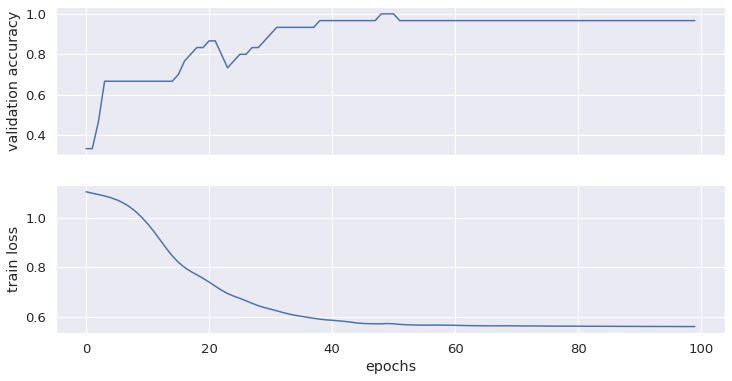

In [15]:
model = IrisPerceptron(
    input_dim=X_train.shape[1], 
    hidden_dim=12,
    hidden_dim_2=20,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

EPOCHS  = 100

X_train = torch.tensor(X_train, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

loss_list = np.zeros((EPOCHS,))
loss_test_list = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm(range(EPOCHS)):
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.float)
        accuracy_list[epoch] = correct.mean().item()

model.eval()

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("train loss")
ax2.set_xlabel("epochs")

with torch.no_grad():
    y_pred = np.argmax(model(X_test).detach().cpu().numpy(), axis=1)

print('\n',
    classification_report(
        y_test.detach().cpu().numpy(), 
        y_pred
    )
)

Размер слоев сильно влияет на качество обучения

## Задание 3. 1 балл
1. Сейчас лосс (функция ошибки) вычисляется только для тренировочного набора данных (хранится в loss_list), создайте массив loss_test_list и сохряняйте в него значения лосс функции для ТЕСТОВОГО набора данных. Отрисуйте loss_test_list на графике ниже. Тренировочные и тестовые кривые должны быть отображены на одном графике разным цветом. Не забудьте добавить легенду


2. Аналогично предыдущему пункту, сейчас accuracy вычисляется только для тестового набора и хранится в accuracy_list, создайте массив accuracy_train_list и сохряняйте в него значения accuracy для ТРЕНИРОВОЧНОГО набора данных. Отрисуйте accuracy_train_list на графике ниже. Тренировочные и тестовые кривые должны быть отображены на одном графике разным цветом. Не забудьте добавить легенду

In [16]:
model_lr001 = IrisPerceptron(
    input_dim=X_train.shape[1], 
    hidden_dim=10,
    hidden_dim_2=30,
).to(device)
optimizer_lr001 = torch.optim.Adam(model_lr001.parameters(), lr=0.01)
criterion_lr001 = nn.CrossEntropyLoss()

EPOCHS  = 100

loss_test_list_model_lr001 = np.zeros((EPOCHS,))
accuracy_train_list_model_lr001 = np.zeros((EPOCHS,))

for epoch in tqdm(range(EPOCHS)):
    model_lr001.train()
    y_pred = model_lr001(X_test)
    loss_test_model_lr001 = criterion_lr001(y_pred, y_test)
    loss_test_list_model_lr001[epoch] = loss_test_model_lr001.item()

    optimizer_lr001.zero_grad()
    loss_test_model_lr001 = criterion_lr001(y_pred, y_test).backward()
    optimizer_lr001.step()

    with torch.no_grad():
        y_pred = model_lr001(X_train)
        correct = (torch.argmax(y_pred, dim=1) == y_train).type(torch.float)
        accuracy_train_list_model_lr001[epoch] = correct.mean().item()    

model_lr001.eval()

  0%|          | 0/100 [00:00<?, ?it/s]

IrisPerceptron(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=3, bias=True)
    (7): Softmax(dim=1)
  )
)

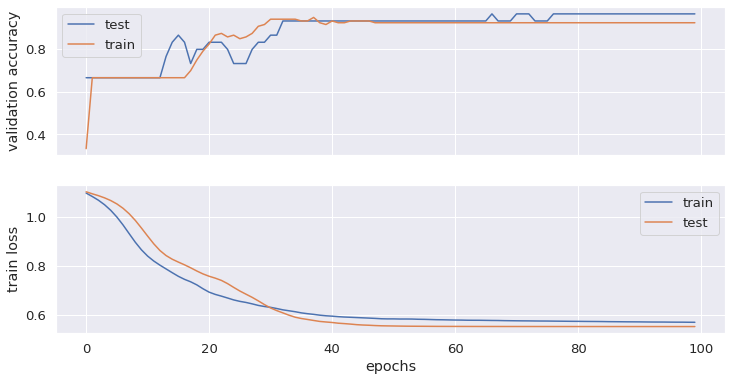

In [17]:
#   ГРАФИКИ РИСУЙТЕ ТУТ
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list_model_lr001)
ax1.plot(accuracy_train_list_model_lr001)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list_model_lr001)
ax2.plot(loss_test_list_model_lr001)
ax2.set_ylabel("train loss")
ax2.set_xlabel("epochs")
ax1.legend(['test', 'train'])
ax2.legend(['train', 'test'])
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

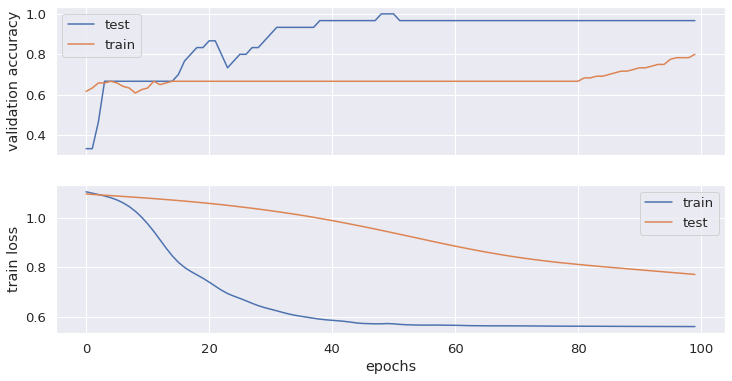

In [18]:
model = IrisPerceptron(
    input_dim=X_train.shape[1], 
    hidden_dim=10,
    hidden_dim_2=30,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

EPOCHS  = 100

loss_test_list = np.zeros((EPOCHS,))
accuracy_train_list = np.zeros((EPOCHS,))

for epoch in tqdm(range(EPOCHS)):
    model.train()
    y_pred = model(X_test)
    loss_test = criterion(y_pred, y_test)
    loss_test_list[epoch] = loss_test.item()

    optimizer.zero_grad()
    loss_test.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred = model(X_train)
        correct = (torch.argmax(y_pred, dim=1) == y_train).type(torch.float)
        accuracy_train_list[epoch] = correct.mean().item()  

model.eval()
  

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.plot(accuracy_train_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.plot(loss_test_list)
ax2.set_ylabel("train loss")
ax2.set_xlabel("epochs")
ax1.legend(['test', 'train'])
ax2.legend(['train', 'test'])
plt.show()

# END